In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np

In [2]:
from irc.manager import IRCManager
from boxforage.utils import plot_multi_box_episode

manager = IRCManager(defaults='irc_defaults/coupled_boxes.yaml')

In [3]:
manager.load_tar('store.tar.gz')

Data from store.tar.gz loaded (0m38.42s).


# Train one agent for a coupled boxes environment

## Train an agent
We train a rational agent for the assume environment parameter $p_\mathrm{appear}=0.2, p_\mathrm{vanish}=0.05, p_\mathrm{cue}=0.8, r_\mathrm{food}=10, r_\mathrm{move}=-0.5, p_\mathrm{couple}=0.2$.

The following can also be done by running `demo-train.py` in command line:
```bash
python demo-train.py env_param=[0.2,0.05,0.8,10,-0.5,0.2] num_epochs=30 defaults=irc_defaults/coupled_boxes.yaml
```

Agent (seed 100) was trained for 80 epochs, RL optimality 100.00%.


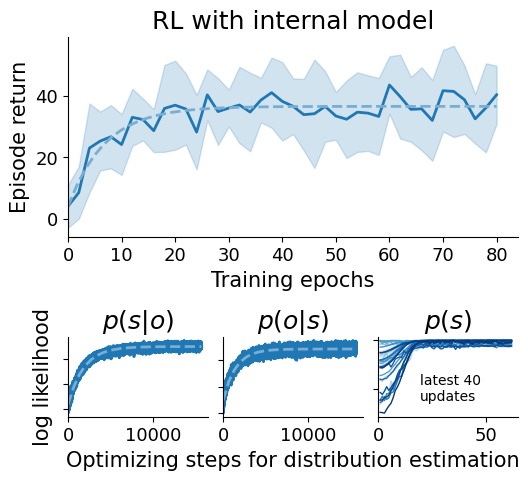

In [4]:
env_param = [0.2, 0.05, 0.8, 10., -0.5, 0.2]
seed = 100

agent, fig = manager.inspect_agent(env_param, seed=seed)

## Run the agent in an environment
We create another environment which has the same observation space and action space as the assumed one, albeit with a different set of environment parameters $(0.25, 0.1, 0.7, 10, -0.5, 0)$. Here $p_\mathrm{couple}=0$ indicates that boxes in the real environment are not coupled.

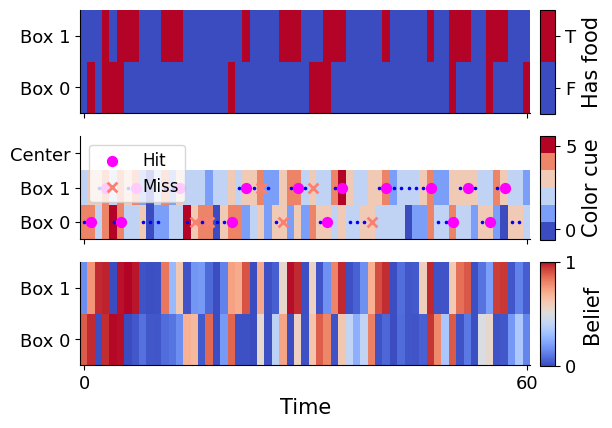

In [5]:
from boxforage.multi_box import SimpleBoxesForaging

env = SimpleBoxesForaging(spec=manager.agent_manager.defaults.env.spec)
env.set_param([0.3, 0.1, 0.6, 10., -0.5, 0])

episode = agent.run_one_episode(env=env, num_steps=60)
fig = plot_multi_box_episode(episode)

In [6]:
import os, pickle

episode_path = 'episode_03.pickle'

if os.path.exists(f'store/{episode_path}'):
    print(f"File store/{episode_path} already exists, will not be overwritten.")
else:
    agent_key = manager.agent_manager.configs.get_key(manager.agent_manager.config)
    trained_epoch = manager.agent_manager.stats[agent_key]['epoch']
    with open(f'store/{episode_path}', 'wb') as f:
        pickle.dump({
            'agent_key': agent_key, 'trained_epoch': trained_epoch,
            'external_env_param': env.get_param(),
            'internal_env_param': agent.model.env.get_param(),
            **episode,
        }, f)
    print(f"Episode data saved at '{episode_path}'.")

Episode data saved at 'episode_03.pickle'.


# Train multiple agents for different environments

## Sweep over parameter grid

We define a grid of environment parameters, and train multiple agents for each of the combination using different random seeds.

The following can also be done by running `demo-sweep.py` in command line:
```bash
python demo-sweep.py num_epochs=10 count=5 defaults=irc_defaults/coupled_boxes.yaml env_param_grid=param_grids/coupled_boxes.yaml
```

Average progress of training 34.2% (20 epochs as complete).
Approximate training time 50m37.43s per epoch.
Approximate evaluation time 5m57.29s.
Average training optimality 94.8%


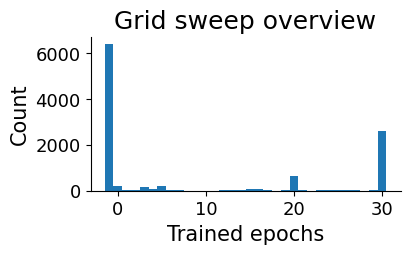

In [7]:
# with open('param_grids/coupled_boxes.yaml', 'r') as f:
#     env_param_grid = yaml.safe_load(f)
env_param_grid = [
    [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], # p_appear
    [0.05, 0.075, 0.1, 0.125, 0.15], # p_vanish
    [0.6, 0.8, 0.9, 0.95], # p_true
    [10.], # r_food
    [-0.5], # r_move
    [-0.4, -0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3, 0.4], # p_couple
]
agent_seeds = list(range(10))

report = manager.overview_agents(env_param_grid=env_param_grid, seeds=agent_seeds, min_epoch=20)

_, ax = plt.subplots(figsize=(4, 2))
ax.hist(report['epoch'], bins=np.arange(min(report['epoch']), max(report['epoch'])+2)-0.5)
ax.set_xlabel('Trained epochs')
ax.set_ylabel('Count')
ax.set_title('Grid sweep overview')
plt.show()

In [ ]:
episode_path = 'episode_01.pickle'

with open(f'store/{episode_path}', 'rb') as f:
    saved = pickle.load(f)
print('External environment parameter: {}'.format(tuple(saved['external_env_param'])))
print('Length of episode: {}'.format(saved['num_steps']))

logps = manager.compute_logps(
    episode_path=episode_path, env_param_grid=env_param_grid,
    agent_seeds=agent_seeds, min_epoch=25, min_optimality=0.98, patience=0,
)

External environment parameter: (0.1, 0.1, 0.6, 10.0, -0.5, 0)
Length of episode: 60
Episode data saved at key 3CBAC7.
Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
425 valid agents found.
Computing likelihood of episode 3CBAC7 (60 time steps)...
------------
Processing FA1861DB (1)...
No checkpoint loaded.
Agent environment parameter:
(0.3, 0.05, 0.6, 10.0, -0.5, -0.2)
Log likelihood of an agent (trained for 30 epochs): -62.288 (0m41.19s)
------------
Processing 82F6A725 (11)...
No checkpoint loaded.
Agent environment parameter:
(0.05, 0.1, 0.8, 10.0, -0.5, -0.4)
Log likelihood of an agent (trained for 30 epochs): -35.807 (0m40.25s)
------------
Processing 2F116148 (21)...
No checkpoint loaded.
Agent environment parameter:
(0.05, 0.125, 0.8, 10.0, -0.5, 0.0)
Log likelihood of an agent (trained for 30 epochs): -28.062 (0m39.23s)
------------
Processing 6537D43B (31)...
No checkpoint loaded.
Agent environment parameter:
(0.15, 0.05, 0.95, 10.0, -0.5, -0.2)
Log likeliho

In [11]:
from irc.utils import logmeanexp

logps = logps.squeeze()
print('squeezed shape {}'.format(logps.shape))

print('removing the log likelihood values of the true agent...')
p_appear, p_vanish, p_true, p_couple = 0.3, 0.1, 0.7, 0.4
agent_seed = 0
logps[
    env_param_grid[0].index(p_appear),
    env_param_grid[1].index(p_vanish),
    env_param_grid[2].index(p_true),
    env_param_grid[5].index(p_couple),
    agent_seed,
] = np.nan

print('averaging log likelihoods over agent seeds and belief seeds...')
logps = logmeanexp(logps, axis=(-2, -1))

squeezed shape (5, 2, 3, 9, 3, 8)
removing the log likelihood values of the true agent...
averaging log likelihoods over agent seeds and belief seeds...


/usr/local/lib/python3.9/dist-packages/irc/utils.py:177: RuntimeWarning: divide by zero encountered in divide
  y = logsumexp(x, b=1/n, axis=axis, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/scipy/special/_logsumexp.py:108: RuntimeWarning: invalid value encountered in multiply
  tmp = b * np.exp(a - a_max)


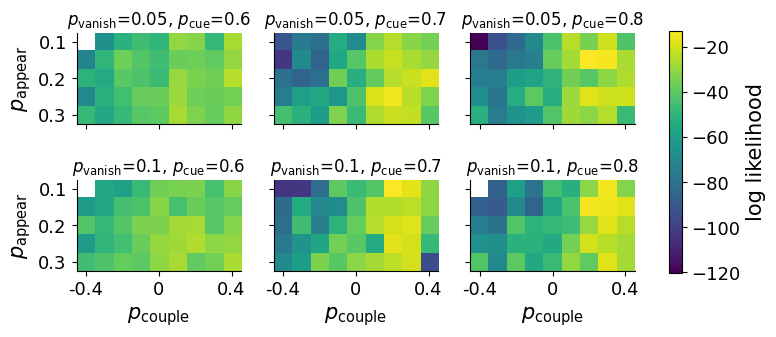

In [12]:
vmin, vmax = np.nanmin(logps), np.nanmax(logps)
_, axes = plt.subplots(2, 3, figsize=(9, 3.5))
for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        h = ax.imshow(logps[:, i, j], vmin=vmin, vmax=vmax)
        ax.set_title(
            r'$p_\mathrm{vanish}$'+'={:g}'.format(env_param_grid[1][i])+', '+r'$p_\mathrm{cue}$'+'={:g}'.format(env_param_grid[2][j]),
            fontsize=12,
        )
        ax.set_xticks([0, 4, 8])
        if i==1:
            ax.set_xlabel(r'$p_\mathrm{couple}$')
            ax.set_xticklabels([-0.4, 0, 0.4])
        else:
            ax.set_xticklabels([])
        ax.set_yticks([0, 2, 4])
        if j==0:
            ax.set_ylabel(r'$p_\mathrm{appear}$')
            ax.set_yticklabels([0.1, 0.2, 0.3])
        else:
            ax.set_yticklabels([])
plt.colorbar(h, ax=axes, shrink=0.9, label='log likelihood')
plt.show()

## Visualize belief distributions

In [13]:
episode = agent.run_one_episode(env=env, num_steps=600)

mean reward 1.770


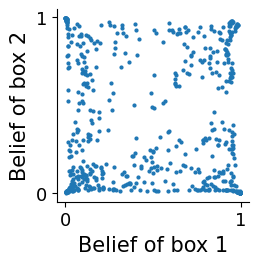

In [14]:
print('mean reward {:.3f}'.format(np.mean(episode['rewards'])))

p_0 = episode['q_probs'][:, [2, 3]].sum(axis=1)
p_1 = episode['q_probs'][:, [1, 3]].sum(axis=1)

_, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(p_0, p_1, s=4)
ax.set_aspect('equal')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel('Belief of box 1')
ax.set_ylabel('Belief of box 2')
plt.show()